In [142]:
# import packages
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import scipy
import matplotlib.pyplot as plt
import plotly
import os
import seaborn as sns

In [5]:
# change viewing options
pd.set_option('display.max_columns', None)  
pd.set_option('max_colwidth', -1)

### Problem: 

Link: https://www.drivendata.org/competitions/66/flu-shot-learning/

**(See bottom for preliminary findings from EDA)**

In this competition, our goal is to try and predict who is likely to get a vaccination. The data comes from the National 2009 H1N1 survey. We're asked to predict whether people (1) get the seasonal vaccine or (2) get the H1N1 vaccine. 

Here is a list of all the covariates and their definitions:

1. h1n1_concern - Level of concern about the H1N1 flu.
   - 0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.
2. h1n1_knowledge - Level of knowledge about H1N1 flu.
   - 0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.
3. behavioral_antiviral_meds - Has taken antiviral medications. (binary)
4. behavioral_avoidance - Has avoided close contact with others with flu-like symptoms. (binary)
5. behavioral_face_mask - Has bought a face mask. (binary)
6. behavioral_wash_hands - Has frequently washed hands or used hand sanitizer. (binary)
7. behavioral_large_gatherings - Has reduced time at large gatherings. (binary)
8. behavioral_outside_home - Has reduced contact with people outside of own household. (binary)
9. behavioral_touch_face - Has avoided touching eyes, nose, or mouth. (binary)
10. doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. (binary)
11. doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor. (binary)
12. chronic_med_condition - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)
13. child_under_6_months - Has regular close contact with a child under the age of six months. (binary)
14. health_worker - Is a healthcare worker. (binary)
15. health_insurance - Has health insurance. (binary)
16. opinion_h1n1_vacc_effective - Respondent's opinion about H1N1 vaccine effectiveness.
    - 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
17. opinion_h1n1_risk - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.
    - 1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
18. opinion_h1n1_sick_from_vacc - Respondent's worry of getting sick from taking H1N1 vaccine.
    - 1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
19. opinion_seas_vacc_effective - Respondent's opinion about seasonal flu vaccine effectiveness.
    - 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
20. opinion_seas_risk - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.
    - 1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
21. opinion_seas_sick_from_vacc - Respondent's worry of getting sick from taking seasonal flu vaccine.
    - 1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
22. age_group - Age group of respondent.
23. education - Self-reported education level.
24. race - Race of respondent.
25. sex - Sex of respondent.
26. income_poverty - Household annual income of respondent with respect to 2008 Census poverty thresholds.
27. marital_status - Marital status of respondent.
28. rent_or_own - Housing situation of respondent.
29. employment_status - Employment status of respondent.
30. hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
31. census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
32. household_adults - Number of other adults in household, top-coded to 3.
33. household_children - Number of children in household, top-coded to 3.
34. employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.
35. employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.

### Step 1: Import data

In [3]:
# check our data
os.listdir()

['data_exploration.ipynb',
 'training_set_labels.csv',
 'submission_format.csv',
 'README.md',
 'training_set_features.csv',
 '.ipynb_checkpoints',
 '.git',
 'test_set_features.csv']

In [6]:
# read in the data
train = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")

### Step 2: Analyze data

Before analyzing the data, I did some background research on the H1N1 and seasonal flu viruses, as well as the associated vaccination responses to each. Based off information from both news outlets and scientific literature, I proposed a few questions to test during data exploration:

#### Question 0: How many people get the H1N1 vaccine? Flu vaccine?

(This question doesn't come from outside sources, but it would be interesting to know the proportion of H1N1 vaccine and flu vaccine adoption, as a whole, prior to further analysis)

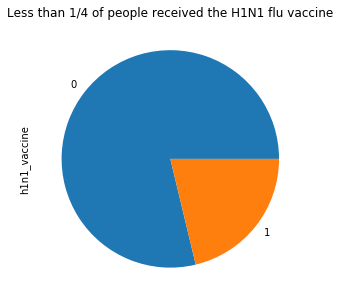

In [121]:
# for the h1n1 vaccine
train_labels['h1n1_vaccine'].value_counts().plot.pie(y="mass", figsize = (5,5))
plt.title("Less than 1/4 of people received the H1N1 flu vaccine")
plt.show()

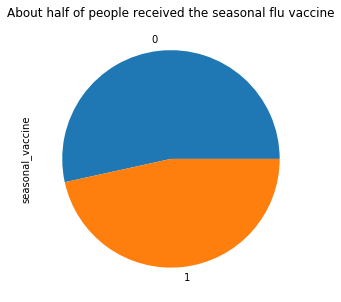

In [120]:
# for the flu vaccine
train_labels['seasonal_vaccine'].value_counts().plot.pie(y="mass", figsize = (5,5))
plt.title("About half of people received the seasonal flu vaccine")
plt.show()

We already see a class imbalance in the adoption of the H1N1 vaccine (less than 1/4 of people chose to receive the H1N1 vaccine), which could be important to keep in mind during future analysis. 

As a follow-up, is there a correlation between adoption of the H1N1 vaccine and the seasonal flu vaccine?

In [122]:
train_labels['h1n1_vaccine'].corr(train_labels['seasonal_vaccine'], method = 'pearson')

0.37714265306144495

We see a mild correlation (r=0.377), which makes sense. If you get one vaccine, you likely will get the other vaccine. How did a person getting or not getting one vaccine influence whether they got the other vaccine? Let's look at this using a table:

In [124]:
tab = pd.crosstab(train_labels['h1n1_vaccine'], train_labels['seasonal_vaccine'])
tab

seasonal_vaccine,0,1
h1n1_vaccine,,
0,13295,7738
1,977,4697


Let's get a better idea of what this table is telling us:

In [129]:
print(f"The percent of people who got both vaccines: {round(tab.iloc[1, 1] * 100/ sum(tab.sum()), 3)}%")
print(f"The percent of people who got neither vaccine: {round(tab.iloc[0, 0] * 100/ sum(tab.sum()), 3)}%")
print(f"The percent of people who got the H1N1 vaccine but not the seasonal flu vaccine: {round(tab.iloc[1, 0] * 100/ sum(tab.sum()), 3)}%")
print(f"The percent of people who got the seasonal flu vaccine but not the H1N1 vaccine: {round(tab.iloc[0, 1] * 100/ sum(tab.sum()), 3)}%")

The percent of people who got both vaccines: 17.587%
The percent of people who got neither vaccine: 49.781%
The percent of people who got the H1N1 vaccine but not the seasonal flu vaccine: 3.658%
The percent of people who got the seasonal flu vaccine but not the H1N1 vaccine: 28.974%


We see that half of respondents got neither vaccine, while only 18% of respondents got both vaccines. A significant proportion, ~29% of respondents, got the seasonal flu vaccine but not the H1N1 vaccine. It might be worth subsetting the dataset by (1) people who got both vaccines, (2) people who got neither vaccine, and (3) people who got the seasonal flu vaccine but not the H1N1 vaccine, and see if we notice any trends.

#### Question 1:  Are people with children more likely to get flu shots? 

Let's analyze this for the H1N1 vaccine first:

In [78]:
# raw counts
pd.crosstab(train['household_children'],  train_labels['h1n1_vaccine'])

h1n1_vaccine,0,1
household_children,,
0.0,14689,3983
1.0,2501,674
2.0,2235,629
3.0,1398,349


In [81]:
# normalized version
tab = pd.crosstab(train['household_children'],  train_labels['h1n1_vaccine'], margins = True, normalize = True)
tab

h1n1_vaccine,0,1,All
household_children,,,
0.0,0.555182,0.150540,0.705722
1.0,0.094527,0.025474,0.120002
2.0,0.084474,0.023774,0.108247
3.0,0.052838,0.013191,0.066029
All,0.787021,0.212979,1.000000


In [82]:
tab['prop_received_medicine'] = tab[1] / (tab[0]  + tab[1]) 

In [52]:
# get tabulation of each
tab = pd.crosstab(train['h1n1_concern'], train_labels['h1n1_vaccine'])
tab_normalized = pd.crosstab(train['h1n1_concern'], train_labels['h1n1_vaccine'], margins = True, normalize = True)

In [57]:
# get proportion of people receiving h1n1 vaccine, by row
tab['prop_received_medicine'] = tab[1] / (tab[0]  + tab[1]) 

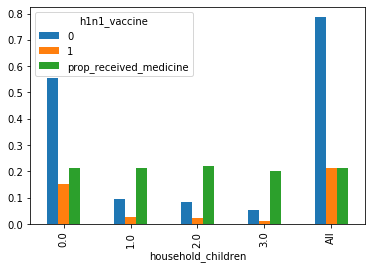

In [84]:
tab[[0, 1, 'prop_received_medicine']].plot(kind = 'bar')
plt.show()

Comment: It seems like the relative proportion of people who received medicine is consistent across the # of children in a household

Now, let's analyze this in the case of the flu virus

In [86]:
# raw counts
pd.crosstab(train['household_children'],  train_labels['seasonal_vaccine'])

seasonal_vaccine,0,1
household_children,,
0.0,9217,9455
1.0,1953,1222
2.0,1769,1095
3.0,1148,599


In [87]:
# normalized version
tab = pd.crosstab(train['household_children'],  train_labels['seasonal_vaccine'], margins = True, normalize = True)
tab

seasonal_vaccine,0,1,All
household_children,,,
0.0,0.348363,0.357359,0.705722
1.0,0.073815,0.046186,0.120002
2.0,0.066861,0.041386,0.108247
3.0,0.043390,0.022640,0.066029
All,0.532429,0.467571,1.000000


In [88]:
# get proportion of people receiving h1n1 vaccine, by row
tab['prop_received_medicine'] = tab[1] / (tab[0]  + tab[1]) 

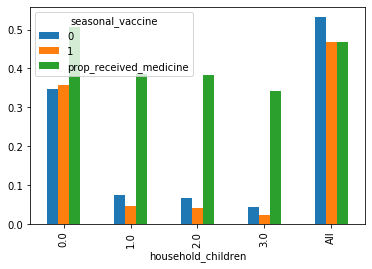

In [89]:
tab[[0, 1, 'prop_received_medicine']].plot(kind = 'bar')
plt.show()

Comment: It seems like people were much more likely to get the seasonal flu vaccine when they didn't have children in the household

General comment: It seems weird that the # of children in the household doesn't affect one's likelihood of getting a H1N1 vaccine, but that those with no children in the household are more likely to get a seasonal vaccine. This seems to go against past news and research (which suggests that people are more likely to get the vaccine if there's people at home who are at risk, such as children and the elderly). I wonder if the findings here are moderated by some other variable. 

#### Question 2: How do vaccination rates vary by age?

Past literature suggests that the elderly are more likely to get vaccinations than any other age groups, and that as one gets older, they become more likely to get vaccination. 

This effect is also likely moderated by the presence of pre-existing conditions (and perhaps other explanatory variables), so it would be good to account for this as well.

Let's first analyze this for the H1N1 vaccine first:

In [102]:
# raw counts
pd.crosstab(train['age_group'],  train_labels['h1n1_vaccine'])

h1n1_vaccine,0,1
age_group,,
18 - 34 Years,4224,991
35 - 44 Years,3087,761
45 - 54 Years,4218,1020
55 - 64 Years,4212,1351
65+ Years,5292,1551


In [103]:
# normalized version
tab = pd.crosstab(train['age_group'],  train_labels['h1n1_vaccine'], margins = True, normalize = True)
tab

h1n1_vaccine,0,1,All
age_group,,,
18 - 34 Years,0.158161,0.037106,0.195267
35 - 44 Years,0.115588,0.028494,0.144082
45 - 54 Years,0.157936,0.038192,0.196128
55 - 64 Years,0.157711,0.050586,0.208297
65+ Years,0.198150,0.058075,0.256225
All,0.787546,0.212454,1.000000


In [104]:
# get proportion of people receiving h1n1 vaccine, by row
tab['prop_received_medicine'] = tab[1] / (tab[0]  + tab[1]) 

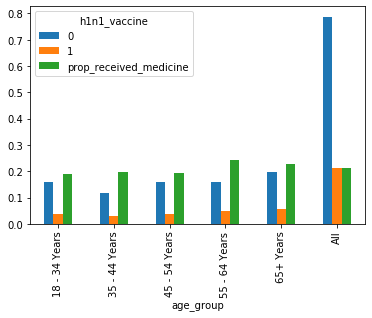

In [105]:
tab[[0, 1, 'prop_received_medicine']].plot(kind = 'bar')
plt.show()

For the H1N1 vaccine, it doesn't seem like age affects how likely a person will get the vaccine.

Now let's analyze this in the case of the flu virus

In [106]:
# raw counts
pd.crosstab(train['age_group'],  train_labels['seasonal_vaccine'])

seasonal_vaccine,0,1
age_group,,
18 - 34 Years,3731,1484
35 - 44 Years,2453,1395
45 - 54 Years,3136,2102
55 - 64 Years,2719,2844
65+ Years,2233,4610


In [107]:
# normalized version
tab = pd.crosstab(train['age_group'],  train_labels['seasonal_vaccine'], margins = True, normalize = True)
tab

seasonal_vaccine,0,1,All
age_group,,,
18 - 34 Years,0.139701,0.055566,0.195267
35 - 44 Years,0.091849,0.052233,0.144082
45 - 54 Years,0.117422,0.078706,0.196128
55 - 64 Years,0.101809,0.106489,0.208297
65+ Years,0.083611,0.172614,0.256225
All,0.534392,0.465608,1.000000


In [108]:
# get proportion of people receiving h1n1 vaccine, by row
tab['prop_received_medicine'] = tab[1] / (tab[0]  + tab[1]) 

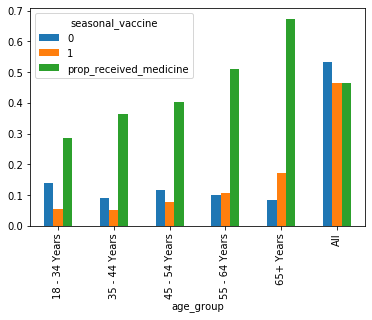

In [109]:
tab[[0, 1, 'prop_received_medicine']].plot(kind = 'bar')
plt.show()

For the seasonal flu vaccine, it seems like the likelihood of getting the vaccine increases as one gets older

#### Question 3: Can we look at stacked bar charts to see how vaccination rates vary by a set of variables that past literature tells us are indicative of vaccination rates?

Rather than looking at bar charts, can we look at stacked bar charts and see how the proportions of vaccination rates vary by each variable?

Note: the following EDA is inspired by this post: https://www.drivendata.co/blog/predict-flu-vaccine-data-benchmark/

In [7]:
# step 1: join the labels and training set
df_joined = train.join(train_labels, on=['respondent_id'], how='inner', rsuffix="_")

In [8]:
df_joined.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id_,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0


In [9]:
# step 2: create a function that creates the vaccination rate plot, by column:
def vaccination_rate_plot(col, target, ax=None):
    """
    Stacked bar plot, plotting the vaccination rates by the column of interest
    
    Args:
        • col: column of interest
        • target: label of interest (h1n1_vaccine or seasonal_vaccine)
        • ax: matplotlib axes object to attach plot to
    """
    
    # get counts table
    counts = pd.crosstab(df_joined[col], df_joined[target])
    
    # get counts, by group in the column
    group_counts = counts.sum(axis='columns')
    
    # get proportions of no vaccination, vaccination, by group
    props = counts.div(group_counts, axis='index')
    
    # plot proportions
    props.plot(kind="barh", stacked=True, ax=ax)
    
    # invert y axis, remove labels
    ax.invert_yaxis()
    ax.legend().remove()

From past news coverage and literature (see links below), what factors seem to affect people's tendency to get the flu vaccine? (in no particular order)
1. Age
2. Gender
3. Education
4. Degree of concern about the virus
5. Degree of awareness about the virus
6. Whether their doctor recommended the vaccine
7. If they have a chronic medical condition
8. If they're in contact with very young children (since the children can be at risk)
9. Their opinion about the vaccine (does it work? Is there a risk? Can they get sick from it?)
10. If they're a healthcare worker (or in the healthcare field). 

****Sources are cited in the bottom of this document.****

So, let's add these columns in a list, loop through each of them, and get a plot of the proportion of vaccination rates

In [10]:
# get columns that could be of interest
cols_to_iterate = ['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
                  'chronic_med_condition', 'child_under_6_months', 'opinion_h1n1_vacc_effective',
                  'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 
                  'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'education', 
                  'sex', 'income_poverty']

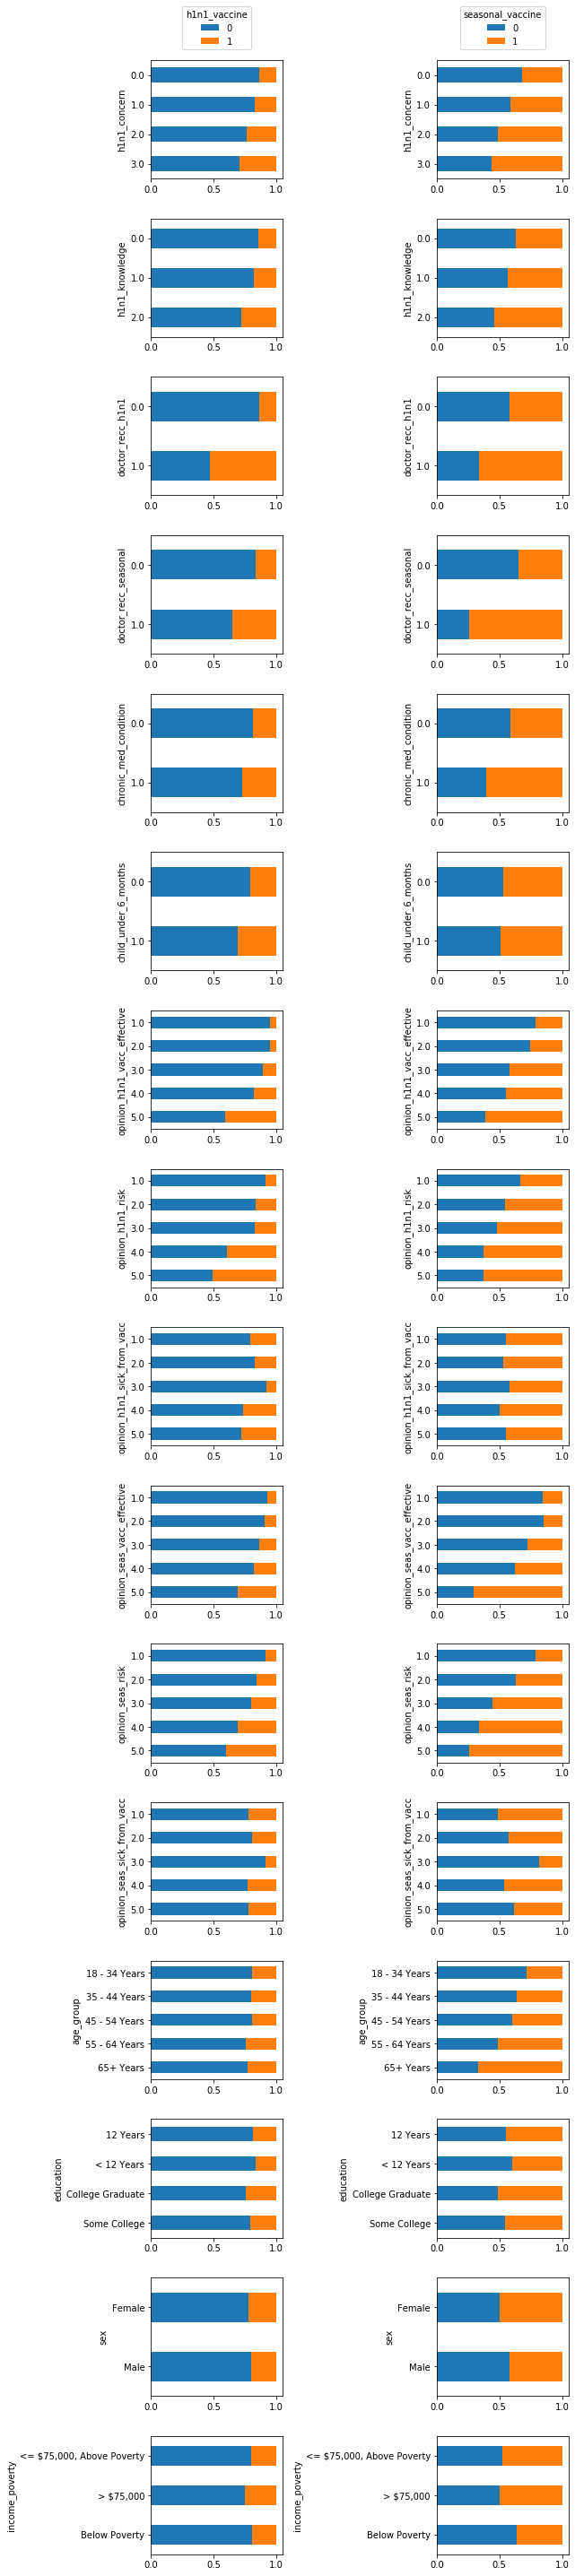

In [160]:
# set up figure, axes
fig, ax = plt.subplots(len(cols_to_iterate), 2, 
                       figsize=(9,len(cols_to_iterate)*2.5))

# iterate through all columns
for index, col in enumerate(cols_to_iterate):
    
    # make first plot, the h1n1 plot
    vaccination_rate_plot(col, 'h1n1_vaccine', ax=ax[index, 0])
    # make second plot, the seasonal flu plot
    vaccination_rate_plot(col, 'seasonal_vaccine', ax=ax[index, 1])
    
# set up labels
ax[0, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
ax[0, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')

# get tight layout
fig.tight_layout()

From the results above, we observe the following:

#### For the H1N1 vaccine, we observe that the following factors correlate with higher rates of vaccination (and seem to be significant? Though a more rigorous statistical test could verify this):
1. Increased H1N1 concern
2. Increase in knowledge about H1N1
3. If their doctor recommended that they get the H1N1 vaccine (half of the people who were recommended the h1n1 vaccine by their doctors eventually got it - though this represents 5,408 out of the 24,547 observations)
4. If their doctor recommended the seasonal vaccine
5. If they have a prior chronic medical condition
6. If they have a child under 6 months
7. If they have a high opinion of the h1n1 vaccine
8. If they have a high opinion of the risk of getting sick without the h1n1 vaccine
9. If they think that the seasonal flu vaccine is effective
10. If they think that the risk of getting sick without the seasonal flu vaccine is high.

Slight effects for the rest of the covariates

#### For the seasonal vaccine, we observe that the following factors correlate with higher rates of vaccination:
1. Increased H1N1 concern
2. Increased knowledge of H1N1
3. Doctor recommended H1N1 vaccine
4. Doctor recommended seasonal flu vaccine (very strong effect)
5. Has chronic medical condition (strong effect)
6. Thinks that H1N1 vaccine is effective
7. Thinks that they're at high risk of getting sick without the H1N1 vaccine
8. Thinks that seasonal flu vaccine is effective (very strong effect)
9. Thinks that they're at high risk of getting sick without the seasonal flu vaccine
10. Age: as people get older, the adoption of seasonal flu vaccine increases
11. Education (some effect - college graduates more likely)
12. Income (some effect - those below poverty less likely)

#### In general, we observe the following:
1. It might be worth investigating the possibility of collinearity (e.g., do the people who receive a doctor's recommendation for the h1n1 virus also receive a recommendation for the seasonal flu virus?)
2. People's opinions about the (a) danger of the virus (b) effectiveness of the vaccine and (c) their own need for the vaccine all seem like strong predictors of their adoption of the vaccine. 
3. Demographic factors, in large part, didn't predict adoption of the vaccine.
4. Age predicted adoption of the seasonal flu vaccine (as people got older, they were more likely to get the seasonal flu vaccine), but not the H1N1 vaccine. 



#### Question 4: How do the covariates relate to each other?

Source: http://seaborn.pydata.org/examples/many_pairwise_correlations.html

Now that we understand how the covariates relate to the outcome variables, let's see how they relate to each other. Let's look at only the numeric variables.

In [17]:
# get numeric columns
numeric_columns = [col for col in train.columns if train[col].dtype == 'float64']

In [39]:
# subset training data
numeric_training_data = train.loc[:, numeric_columns]

In [20]:
# get correlation matrix
corr_matrix = numeric_training_data.corr()

In [33]:
# what is the maximum correlation? (apart from the diagonals)
np.max(np.tril(corr_matrix, k = -1))

0.5918676633641384

In [23]:
# generate upper triangle mask
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

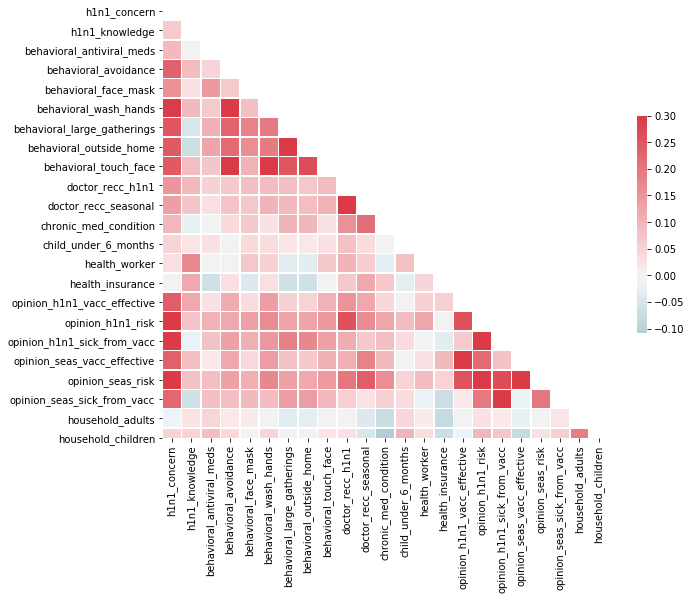

In [25]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})
plt.show()

#### Comments

As we'd expect, the covariates regarding people's opinions about the vaccine's efficacy have a strong positive correlation. 

Moreover, we also observe that certain behavioral metrics (e.g., how often people go out into large crowds or how often they touch their face) correlate with their concern about the flu. 

I was surprised by the weak correlations that the number of children in the household had with the measures - past literature suggested that if a household has more children, they'd be more in support of the vaccine because children are at risk. However, we also see that 'child_under_6_months' covariate has a slight positive correlation with all the metrics, suggesting that if there is a child in the household, then that adult will be more likely to get a vaccine. One way to explain these two results is to perhaps conclude that if there are "older" children in the household, their parents may not think that they're at risk to catch the flu, whereas parents believe that young children are particularly susceptible to catching the flu. 



#### Question 5: Could we run a preliminary model and see what the relative feature importance is?

Source: https://machinelearningmastery.com/calculate-feature-importance-with-python/
Source: https://towardsdatascience.com/data-science-for-startups-exploratory-data-analysis-70ac1815ddec

Our previous graphs tell us how the covariates relate to each other and to the outcome variables. Without delving too much into the modelling aspect, could we create a preliminary model that takes all the covariates into account and observes which ones seem to be more important than the others?

Let's use, in this first stab, the numeric covariates (so as to not have to one-hot-encode at the moment). This seems ok because, from our past EDA and from past literature, it seems like our numeric covariates (e.g., the ones that test people's opinions about the flu, as well as their past behavior) are likely the variables that are most predictive of flu vaccination rates. 

At the moment, let's impute any NaNs with the median value.

In [45]:
# check for NaNs
numeric_training_data.isnull().sum()

h1n1_concern                   92   
h1n1_knowledge                 116  
behavioral_antiviral_meds      71   
behavioral_avoidance           208  
behavioral_face_mask           19   
behavioral_wash_hands          42   
behavioral_large_gatherings    87   
behavioral_outside_home        82   
behavioral_touch_face          128  
doctor_recc_h1n1               2160 
doctor_recc_seasonal           2160 
chronic_med_condition          971  
child_under_6_months           820  
health_worker                  804  
health_insurance               12274
opinion_h1n1_vacc_effective    391  
opinion_h1n1_risk              388  
opinion_h1n1_sick_from_vacc    395  
opinion_seas_vacc_effective    462  
opinion_seas_risk              514  
opinion_seas_sick_from_vacc    537  
household_adults               249  
household_children             249  
dtype: int64

In [47]:
# impute missing values
imp_train = SimpleImputer(missing_values = np.nan, strategy = 'median')

# fit imputer objects
train_numeric_imputed = pd.DataFrame(imp_train.fit_transform(numeric_training_data),
                                     columns = numeric_training_data.columns)

In [48]:
# create logistic regression objects
h1n1_model = LogisticRegression()
seasonal_model = LogisticRegression()

In [49]:
# fit models
h1n1_model.fit(train_numeric_imputed, train_labels['h1n1_vaccine'])
seasonal_model.fit(train_numeric_imputed, train_labels['seasonal_vaccine'])

/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Now, let's plot the feature importance for each logistic regression

#### For whether or not a person gets the H1N1 vaccine

In [52]:
# get feature importance values
h1n1_importance = h1n1_model.coef_[0]

Importance for the 'h1n1_concern' column (Column # 0) : -0.09628876880822293
Importance for the 'h1n1_knowledge' column (Column # 1) : 0.15418981980004667
Importance for the 'behavioral_antiviral_meds' column (Column # 2) : 0.11673788856082062
Importance for the 'behavioral_avoidance' column (Column # 3) : -0.039910433601361144
Importance for the 'behavioral_face_mask' column (Column # 4) : 0.17227973570007196
Importance for the 'behavioral_wash_hands' column (Column # 5) : -0.006471533651793797
Importance for the 'behavioral_large_gatherings' column (Column # 6) : -0.19804308353804695
Importance for the 'behavioral_outside_home' column (Column # 7) : -0.030262639181693793
Importance for the 'behavioral_touch_face' column (Column # 8) : 0.03468981763801026
Importance for the 'doctor_recc_h1n1' column (Column # 9) : 1.9681562056957875
Importance for the 'doctor_recc_seasonal' column (Column # 10) : -0.41162446013439763
Importance for the 'chronic_med_condition' column (Column # 11) : 0.

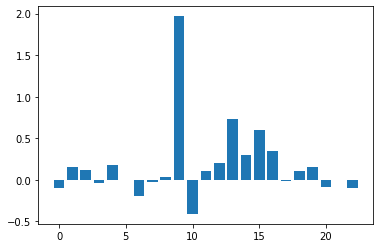

In [65]:
# summarize feature importance
for index, (col_name,importance) in enumerate(zip(train_numeric_imputed.columns, h1n1_importance)):
    print(f"Importance for the '{col_name}' column (Column # {index}) : {importance}")
# plot feature importance
plt.bar([x for x in range(len(h1n1_importance))], h1n1_importance)
plt.show()

In [82]:
# how does a person's opinions about their H1N1 risk level vary by whether they received a H1N1 vaccine rec?
pd.crosstab(train['doctor_recc_h1n1'],  train['opinion_h1n1_risk'], margins = True, normalize = 'index')

opinion_h1n1_risk,1.0,2.0,3.0,4.0,5.0
doctor_recc_h1n1,,,,,
0.0,0.349175,0.397542,0.043357,0.165673,0.044253
1.0,0.174497,0.307420,0.033184,0.340418,0.144482
All,0.310652,0.377667,0.041113,0.204210,0.066357


#### Comment

From this feature importance chart, it seems like the features that are most important in predicting whether a person gets the flu vaccine are (1) if their doctor recommends it - this is much stronger than any other factor, (2) if they're a health worker, (3) if they think that the H1N1 vaccine is effective, and (4) if they think that they're at risk if they don't get the H1N1 vaccine. 

I was surprised to find out how effectively we were able to predict if a person would get the H1N1 vaccine based solely on if their doctor recommended it or not - this was much more predictive than any other factor. We saw that only 25% of people in the survey received the H1N1 vaccine, but up to 50% of people who received a recommendation from their doctor to receive the H1N1 vaccine ended up receiving the vaccine (as opposed to 10% of people who did not receive a recommendation from their doctor to receive the H1N1 vaccine). Only 22% of participants were recommended to receive the H1N1 vaccine from their doctor (5,408 out of 24,547 participants) - this is in contrast to the 33% of participants who were recommended to receive the seasonal flu vaccine from their doctor. 

One way to explain this effect would be to suggest that if a participant received a recommendation from a doctor to receive the H1N1 vaccine, then the participant likely sees the H1N1 flu as a threat. This is at least somewhat true - we see that a participant's opinion about their risk levels for H1N1 positively correlate with their probability of receiving a vaccine. Moreover, as per the table above, we see that 48% of participants who received an H1N1 vaccine recommendation from their doctor rated their opinion about their own H1N1 risk levels to be either a 4 or 5 (in contrast, for participants who didn't receive the recommendation, only 20% believed their risk levels to be either a 4 or 5). On one hand, this could be a chicken-and-egg problem: did the participant already believe themselves to be at risk, and the doctor reinforce it, or vice versa? Plus, the people who received a recommendation from a doctor to receive the vaccine are those who went to see the doctor in the first place, while those who didn't receive a recommendation from a doctor may or may not have even seen a doctor (which creates a possible self-selecting bias in our data as well). 

But, I think it's valid to assume that if a doctor were to recommend the vaccine, a participant is more likely to believe that they're at risk if they don't receive it, and this further exacerbates whatever risks or concerns they already had, which could explain why a doctor's recommendation is the strongest predictor for if a person gets the H1N1 flu vaccine

#### For whether or not a person gets the seasonal flu vaccine

In [67]:
# get feature importance
seasonal_importance = seasonal_model.coef_[0]

Importance for the 'h1n1_concern' column (Column # 0) : 0.03600025446663148
Importance for the 'h1n1_knowledge' column (Column # 1) : 0.18367420091533165
Importance for the 'behavioral_antiviral_meds' column (Column # 2) : -0.06917692071251408
Importance for the 'behavioral_avoidance' column (Column # 3) : -0.043685371798794836
Importance for the 'behavioral_face_mask' column (Column # 4) : 0.015085831886384553
Importance for the 'behavioral_wash_hands' column (Column # 5) : 0.06847631141482038
Importance for the 'behavioral_large_gatherings' column (Column # 6) : 0.005258714881993659
Importance for the 'behavioral_outside_home' column (Column # 7) : -0.02430975085569697
Importance for the 'behavioral_touch_face' column (Column # 8) : 0.24837288968905408
Importance for the 'doctor_recc_h1n1' column (Column # 9) : -0.33753821941718987
Importance for the 'doctor_recc_seasonal' column (Column # 10) : 1.5445135149660183
Importance for the 'chronic_med_condition' column (Column # 11) : 0.34

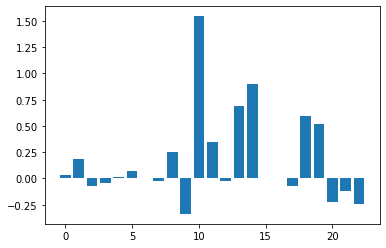

In [68]:
# summarize feature importance
for index, (col_name,importance) in enumerate(zip(train_numeric_imputed.columns, seasonal_importance)):
    print(f"Importance for the '{col_name}' column (Column # {index}) : {importance}")
# plot feature importance
plt.bar([x for x in range(len(seasonal_importance))], seasonal_importance)
plt.show()

In [87]:
# how does a person's opinions about their flu risk level vary by whether they received a flu vaccine rec?
pd.crosstab(train['doctor_recc_seasonal'],  train['opinion_seas_risk'], margins = True, normalize = 'index')

opinion_seas_risk,1.0,2.0,3.0,4.0,5.0
doctor_recc_seasonal,,,,,
0.0,0.274085,0.373388,0.024687,0.246066,0.081775
1.0,0.135767,0.274659,0.025128,0.386798,0.177647
All,0.228370,0.340757,0.024833,0.292579,0.113462


In [88]:
pd.crosstab(train['doctor_recc_seasonal'],  train['opinion_seas_vacc_effective'], margins = True, normalize = 'index')

opinion_seas_vacc_effective,1.0,2.0,3.0,4.0,5.0
doctor_recc_seasonal,,,,,
0.0,0.054532,0.100499,0.056565,0.475199,0.313205
1.0,0.029173,0.049869,0.022067,0.380626,0.518265
All,0.046144,0.083753,0.045155,0.443918,0.381031


#### Conclusion

We can make similar conclusions to our analysis of the H1N1 vaccine above. The strongest predictor, by far, seems to be whether or not a doctor recommended the seasonal vaccine. We also see that whether or not a doctor recommended the seasonal vaccine correlates with how a participant sees their own risk levels for the seasonal flu as well as the effectiveness of the seasonal flu vaccine (though this doesn't quite show causation): if a doctor recommended the seasonal flu vaccine, a participant was more likely to believe that they'd be at risk to become sick with the seasonal flu and that obtaining the seasonal flu vaccine would be effective. 

However, it was also interesting to observe that whether or not a participant was a health worker or had health insurance were both also strong features in predicting if a person received the seasonal flu vaccine.

Let's look at health insurance:

In [93]:
pd.crosstab(train['health_insurance'],  train_labels['seasonal_vaccine'], margins = True, normalize = 'index')

seasonal_vaccine,0,1
health_insurance,,
0.0,0.770737,0.229263
1.0,0.461999,0.538001
All,0.499134,0.500866


In [94]:
train['health_insurance'].value_counts()

1.0    12697
0.0    1736 
Name: health_insurance, dtype: int64

Let's look at whether they're a health worker:

In [92]:
pd.crosstab(train['health_worker'],  train_labels['seasonal_vaccine'], margins = True, normalize = 'index')

seasonal_vaccine,0,1
health_worker,,
0.0,0.554382,0.445618
1.0,0.352880,0.647120
All,0.531830,0.468170


In [109]:
train['health_worker'].value_counts()

0.0    23004
1.0    2899 
Name: health_worker, dtype: int64

In [104]:
pd.crosstab(train['health_worker'],  train_labels['seasonal_vaccine'])

seasonal_vaccine,0,1
health_worker,,
0.0,12753,10251
1.0,1023,1876


We see that the values are pretty skewed, but we also see that the base rates are skewed (88% of participants had health insurance level, out of those participants for whom we had that information; 11% of participants were health workers). We can do statistical tests to see if this difference is significant (using a chi-square test).

For our expected values, we assume that getting the seasonal vaccine isn't related to whether a person has health insurance or whether they're a health worker. Therefore, we calculate our expected values for each cell as 0.5 * expected # of people in that condition. For example, if 10% of people are health workers, we expect that 0.5 * 0.1 * (total # of participants) people would get the vaccine. We'd assume the same for people who don't get the vaccine, since here we're assuming that whether or not one gets the vaccine doesn't depend on their status.

Let's start with looking at health insurance

In [118]:
# our actual observations
pd.crosstab(train['health_insurance'],  train_labels['seasonal_vaccine'])

seasonal_vaccine,0,1
health_insurance,,
0.0,1338,398
1.0,5866,6831


In [128]:
# our expected counts
expected_counts_health_insurance = [[0.5 * (train['health_insurance'].value_counts()[0] / train['health_insurance'].value_counts().sum()) * train['health_insurance'].value_counts().sum(), 
                                     0.5 * (train['health_insurance'].value_counts()[0] / train['health_insurance'].value_counts().sum()) * train['health_insurance'].value_counts().sum()], 
                                    [0.5 * (train['health_insurance'].value_counts()[1] / train['health_insurance'].value_counts().sum()) * train['health_insurance'].value_counts().sum(), 
                                     0.5 * (train['health_insurance'].value_counts()[1] / train['health_insurance'].value_counts().sum()) * train['health_insurance'].value_counts().sum()]]
print(expected_counts_health_insurance)


[[868.0, 868.0], [6348.5, 6348.5]]


In [129]:
# for how health insurance relates to getting the seasonal vaccine
scipy.stats.chisquare(pd.crosstab(train['health_insurance'],  
                                  train_labels['seasonal_vaccine']), 
                      f_exp = expected_counts_health_insurance)


Power_divergenceResult(statistic=array([291.16415159, 291.16415159]), pvalue=array([2.77268124e-65, 2.77268124e-65]))

Now let's look at one's status as a health worker 

In [130]:
# our actual observations
pd.crosstab(train['health_worker'],  train_labels['seasonal_vaccine'])

seasonal_vaccine,0,1
health_worker,,
0.0,12753,10251
1.0,1023,1876


In [131]:
# our expected counts
expected_counts_health_worker = [[0.5 * (train['health_worker'].value_counts()[0] / train['health_worker'].value_counts().sum()) * train['health_worker'].value_counts().sum(), 
                                  0.5 * (train['health_worker'].value_counts()[0] / train['health_worker'].value_counts().sum()) * train['health_worker'].value_counts().sum()], 
                                 [0.5 * (train['health_worker'].value_counts()[1] / train['health_worker'].value_counts().sum()) * train['health_worker'].value_counts().sum(), 
                                  0.5 * (train['health_worker'].value_counts()[1] / train['health_worker'].value_counts().sum()) * train['health_worker'].value_counts().sum()]]
print(expected_counts_health_worker)


[[11502.0, 11502.0], [1449.5, 1449.5]]


In [132]:
# for how being a health worker relates to getting the seasonal vaccine
scipy.stats.chisquare(pd.crosstab(train['health_worker'],  
                                  train_labels['seasonal_vaccine']), 
                     f_exp = expected_counts_health_worker)


Power_divergenceResult(statistic=array([261.55648135, 261.55648135]), pvalue=array([7.85677282e-59, 7.85677282e-59]))

#### Comments

We see (thanks to the chi-squared test) that having health insurance or being a health worker significantly affects whether or not one gets the seasonal flu vaccine (but doesn't indicate the direction, instead indicating that there is at least a significant relationship). From looking at the tables, we observe that if one doesn't have health insurance, they are less likely to get the seasonal flu vaccine (and if they do have health insurance, they are more likely to get health insurance). We also observe that if one isn't a health worker, they are less likely to get the seasonal flu vaccine (but if they are a health worker, they are more likely to get the seasonal flu vaccine). 

This suggests that perhaps one way to promote adoption of the seasonal flu vaccine is to provide easier access to the vaccine for those who do not have health insurance. 

But, could it also be the case that people who don't have health insurance are less likely to see a doctor? We don't have a question that directly answers this, but we can hypothesize that this could explain, in part, our observed effect. 

These resources seem to suggest that, as we'd expect, people without health insurance are less likely to see a doctor: 
1. https://www.kff.org/uninsured/issue-brief/key-facts-about-the-uninsured-population/
2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4351276/

Therefore, I would expect that if people without health insurance were to see a doctor, they would be more likely to get the seasonal flu vaccine (if it were within their means to afford it, of course, which is another complication to be considered). My initial hypothesis would be that our observed effect (that people without health insurance are less likely to get the seasonal flu vaccine) would be more likely to do so if they were to nudged to and given the opportunity to see a doctor. 

In the table below, we see that people without health insurance were advised to get the seasonal flu vaccine only 19% of the time, while people with insurance were advised to get the seasonal flu vaccine 37% of the time. Barring any difference in measures such as health, it would seem to be that the only relevant difference between the two groups is that those without health insurance are less likely to see a doctor in the first place. 

In [141]:
pd.crosstab(train['health_insurance'],  train['doctor_recc_seasonal'], normalize = 'index')

doctor_recc_seasonal,0.0,1.0
health_insurance,,
0.0,0.805539,0.194461
1.0,0.634497,0.365503


I also would like to do some further exploration of the health workers - in particular, I'd like to see if differences in health opinions explain why health workers are more likely to get the vaccine than non-health workers. 

In [136]:
for col in ['opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']:
    print("======================")
    print(f"Now printing cross-table for the following column: {col}")
    print(pd.crosstab(train['health_worker'],  train[col], normalize = 'index'))

Now printing cross-table for the following column: opinion_seas_vacc_effective
opinion_seas_vacc_effective       1.0       2.0       3.0       4.0       5.0
health_worker                                                                
0.0                          0.046816  0.084531  0.047731  0.443298  0.377624
1.0                          0.035579  0.078411  0.024870  0.448014  0.413126
Now printing cross-table for the following column: opinion_seas_risk
opinion_seas_risk       1.0       2.0       3.0       4.0       5.0
health_worker                                                      
0.0                0.232564  0.351981  0.026165  0.282368  0.106922
1.0                0.183293  0.264066  0.017259  0.369348  0.166034
Now printing cross-table for the following column: opinion_seas_sick_from_vacc
opinion_seas_sick_from_vacc       1.0       2.0       3.0       4.0       5.0
health_worker                                                                
0.0                          0.44

From a cursory analysis, it seems like healthcare workers more strongly believe that the seasonal flu vaccine is effective and that they might be at risk if they don't get the vaccine, but it doesn't seem like it would be statistically significant. These factors likely do not explain why healthcare workers are significantly more likely to get the seasonal flu vaccine than non-healthcare workers. 

I can conduct analyses later to delve deeper into this relationship, but at the moment it suffices to show that healthcare workers are more likely to get the seasonal flu vaccine. 

### Conclusion

From this EDA, we have a general sense of which factors correlate with vaccination rates. It seems to corrobate past literature on factors that influence people's proclivity for vaccination rates. 

More than anything else, we see that a doctor's recommendation seems to be the biggest influencing factor for whether or not a person receives a vaccine. This relationship isn't necessarily causal (for example, the people who see a doctor might be proactive anyways or be predisposed to believe that they're at risk), but it might suggest that one big first step in encouraging people to receive vaccines is to have them see a doctor in the first place. Logically, this makes sense - a doctor can address the concerns that a person has about receiving a vaccine, and people might be more likely to receive the vaccine after having discussed it with an authoritative expert in the matter.

At the moment, I'll use these insights for my first stab at the problem. 

Some of the preliminary findings are: 

1. Whether or not a doctor recommended a person to get a vaccine was the strongest predictor of if a person got either the H1N1 or the seasonal flu vaccine. However, this may not necessarily be causal. For example, this might just indicate that people who go see the doctor are inclined to be more careful with their health - so, our observed effect might be due to a selection bias. 

2. People without health insurance are less likely to get the seasonal flu vaccine, though this just might be due to the fact that people without health insurance are less likely to see a doctor and therefore less likely to be advised that they need the flu vaccine. 

3. Healthcare workers are more likely to get the seasonal flu vaccine than non-healthcare workers, but it doesn't seem to be due to the fact that they think the seasonal flu is more dangerous than do their counterparts. 

4. Having children in the household somewhat predicts if a person is likely to get the H1N1 or seasonal flu vaccine - but this seems to only be the case if one has a very young child (e.g., 6 months old) who has yet to develop a strong immune system. 

5. Those with pre-existing conditions see themselves as more likely to get sick from either the H1N1 or the seasonal flu, and they're also more likely to get the associated vaccines (likely as a result of these beliefs).

From this, it seems like the two most relevant interventions for promoting vaccine adoption are:

1. Increase access to and spread of information regarding the flu - as people's awareness of either the H1N1 or the seasonal flu increases, they tend to be more likely to get the vaccine. 

2. Get people to see their doctors - whether or not a doctor told someone to get a vaccine was the strongest predictor of whether or not they got the vaccine. It is possible that people who see their doctor are more wary about their health in the first place, just as it is possible that poeple who weren't recommended by their doctor to get the vaccine just hadn't seen their doctor in the first place. However, it would logically make sense that seeing a doctor would nudge a person to get the vaccine if the doctor were to advise them to do so. 

Subsequent attempts could look into:

1. Determining which factors are collinear
2. Feature engineering
3. Use more of the covariates (I took a subset of the covariates, the ones that I thought would be important based off past literature)
4. Use different covariates for predicting each outcome (for example, it might not make sense to use a person's opinions about H1N1 to predict their probability of getting the seasonal flu vaccine)

### Sources

Below are the sources that I used in my research for this project (not including help with StackOverflow or the pandas/numpy/matplotlib documentation)

Agüero, F., Adell, M. N., Pérez Giménez, A., López Medina, M. J., & Garcia Continente, X. (2011). Adoption of preventive measures during and after the 2009 influenza A (H1N1) virus pandemic peak in Spain. Preventive Medicine, 53(3), 203–206. https://doi.org/10.1016/j.ypmed.2011.06.018

Betsch, C., & Wicker, S. (2012). E-health use, vaccination knowledge and perception of own risk: Drivers of vaccination uptake in medical students. Vaccine, 30(6), 1143–1148. https://doi.org/10.1016/j.vaccine.2011.12.021

Ramsey, M. A., & Marczinski, C. A. (2011). College students’ perceptions of H1N1 flu risk and attitudes toward vaccination. Vaccine, 29(44), 7599–7601. https://doi.org/10.1016/j.vaccine.2011.07.130

Velan, B., Kaplan, G., Ziv, A., Boyko, V., & Lerner-Geva, L. (2011). Major motives in non-acceptance of A/H1N1 flu vaccination: The weight of rational assessment. Vaccine, 29(6), 1173–1179. https://doi.org/10.1016/j.vaccine.2010.12.006

"2009 H1N1 Epidemic", CDC website, https://www.cdc.gov/flu/pandemic-resources/2009-h1n1-pandemic.html

"The Other Reasons People Don't Get Vaccines", Scientific American, https://blogs.scientificamerican.com/observations/the-other-reasons-people-dont-get-vaccines/

"Many Americans Believe They Don't Need the Flu Vaccine", NPR, https://www.npr.org/sections/health-shots/2015/11/27/456202280/many-americans-believe-they-dont-need-the-flu-vaccine

"Almost Half of US Adults to Skip Flu Shot", WebMD, https://www.webmd.com/cold-and-flu/news/20181210/almost-half-of-us-adults-to-skip-flu-shot#1

"Who Don't People Get the Flu Shot?", Seeker, https://www.seeker.com/why-dont-people-get-the-flu-shot-1766370718.html

Tolbert, J., Orgera, K., & Singer, N. (2019). "Key Facts about the Uninsured Population". https://www.kff.org/uninsured/issue-brief/key-facts-about-the-uninsured-population/

Taber, J.M., Leyva, B., & Persoskie, A. (2015). "Why do People Avoid Medical Care? A Qualitative Study Using National Data". https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4351276/